In [1]:
#necessary libraries 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#load data from original csv file
#function to load and return Dataframe
def loadData(csv):
    data = pd.read_csv(csv)
    return data

In [3]:
#run function to obtain dataframe 
heart_data = loadData("heart.csv")
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
#function to get basic info from the df
def basicInfo(data):
    print(data.shape)
    print(data.info())

In [5]:
basicInfo(heart_data)

(918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [6]:
#function to deal with categorical features 
#function to check for any missing values
def categorical_features(data):
    cat_features = data.select_dtypes(include='object').columns
    #store in a list for encoding later and save num_cols for plotting
    cat_f = cat_features.to_list()
    num_features = data.select_dtypes(include=['int64', 'float64']).columns.to_list()
    
    return cat_f, num_features

def check_for_missing(data):
    print(data.isna().any())

In [7]:
cat_features = []
num_features = []
if len(cat_features) == 0:
    cat_features, num_features = categorical_features(heart_data)

In [8]:
check_for_missing(heart_data)

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool


In [9]:
#modeling 
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier

#metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, plot_confusion_matrix, roc_curve, auc

In [10]:
#We have no missing values and have separated our categorical features from our numerical features
#Upon Exploration there are different ranges in the numerical values in the data that need to be scaled
#Choose to use MinMax scaler to bring all values within same range while maitaining same distribution as original data
from sklearn.preprocessing import MinMaxScaler

def getDummyDf(df):
    data_origin = df.copy()
    
    df['Sex'].dtype
    if df['Sex'].dtype != 'int64':
        df['Sex'] = df['Sex'].replace(to_replace=['M', 'F'], value=[1,0])
        
    if df['ExerciseAngina'].dtype != 'int64':
        df['ExerciseAngina'] = df['ExerciseAngina'].replace(to_replace=['N', 'Y'], value=(0,1))
        
    df = pd.get_dummies(df)
    return df

In [61]:
df = getDummyDf(heart_data)
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1


In [12]:
#drop target into its own column
target = df['HeartDisease']
if 'HeartDisease' in df.columns:
    df.drop(labels='HeartDisease', axis=1, inplace=True)

X = df.copy()
y = target

In [13]:
def preprocessing(X,y):
    #split the data using simple train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_test_sc = pd.DataFrame(X_test_scaled, columns = X.columns)
    X_train_sc = pd.DataFrame(X_train_scaled, columns = X.columns)
    
    return X_test_sc, X_train_sc, y_train, y_test, scaler

In [14]:
X_test_scaled, X_train_scaled, y_train, y_test, minMax = preprocessing(X, y)
X_train_scaled.describe()
#heart_data_scaled, minMaxScaler = MinMax(heart_data)
#heart_data_scaled.describe()

(642, 18) (276, 18)
(642,) (276,)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,642.000000,642.00000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.00000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,0.520281,0.79595,0.663707,0.335111,0.232087,0.534021,0.403427,0.396807,0.532710,0.186916,0.23053,0.049844,0.214953,0.598131,0.186916,0.066978,0.517134,0.415888
std,0.192391,0.40332,0.094774,0.182150,0.422494,0.183141,0.490967,0.121753,0.499318,0.390148,0.42150,0.217793,0.411110,0.490658,0.390148,0.250179,0.500096,0.493259
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.372449,1.00000,0.600000,0.293532,0.000000,0.404676,0.000000,0.295455,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.530612,1.00000,0.650000,0.373134,0.000000,0.546763,0.000000,0.357955,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.653061,1.00000,0.700000,0.447761,0.000000,0.669065,1.000000,0.477273,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
#method to interchangeable test classifiers on the data
#has metrics confusion matrix to test tp/Fp
def clf_fit_predict(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    print(f"The score for the train set is: {clf.score(X_train, y_train)}")
    print(f"The score for the test set is: {clf.score(X_test, y_test)}")
    
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    acc = roc_auc_score(y_test, y_pred)
    print(f"The accuracy of the model is: {acc}")
    
    plot_confusion_matrix(clf, X_test, y_test)
    
    return clf

The score for the train set is: 1.0
The score for the test set is: 0.8731884057971014
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       126
           1       0.87      0.90      0.89       150

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276

The accuracy of the model is: 0.8706349206349205


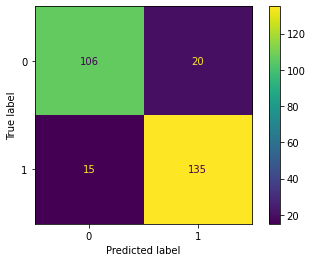

In [16]:
#I chose the RandomForest because it made the most intitial sense for the data
#it also performed the best out of the classifier I tried
clf = clf_fit_predict(RandomForestClassifier(), X_train_scaled, X_test_scaled, y_train, y_test)

The score for the train set is: 0.9283489096573209
The score for the test set is: 0.8768115942028986
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       126
           1       0.86      0.92      0.89       150

    accuracy                           0.88       276
   macro avg       0.88      0.87      0.87       276
weighted avg       0.88      0.88      0.88       276

The accuracy of the model is: 0.8726984126984126


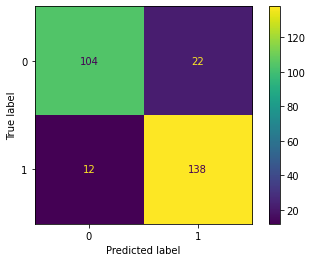

In [17]:
#hyperparameter tuning for the RFC
#most of the hyperparameter tuning I tried was trial and error, the following were the best parameters that 
#sqeezed some more performance from the model
forest = RandomForestClassifier(max_depth=90, max_features='log2', max_leaf_nodes=50, min_samples_leaf=3, min_samples_split=8,)

clf = clf_fit_predict(forest, X_train_scaled, X_test_scaled, y_train, y_test)

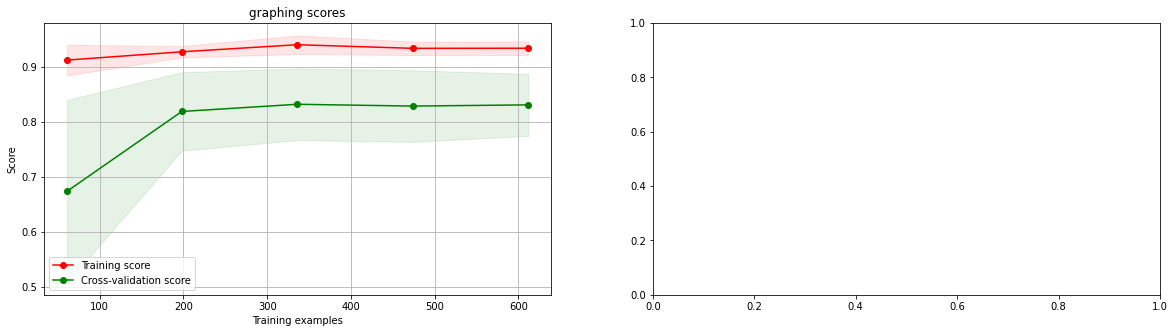

In [18]:
#plotted the learning curve to see how the model learns
from sklearn.model_selection import learning_curve

_, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].set_title("graphing scores")

axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(forest, X, y, cv=3, scoring='accuracy', random_state=3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
axes[0].grid()
axes[0].fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
axes[0].fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
axes[0].plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
axes[0].plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
axes[0].legend(loc="best")

In [19]:
headers = df.columns
headers.shape

headers_df = pd.DataFrame(columns=headers)
headers_df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up


In [88]:
json_str = '''{"0":{"Age": "52", "Sex": "M", "ChestPainType": "ASY", "RestingBP": "170", "Cholesterol": "215", 
            "FastingBS": "0", "RestingECG": "Normal", "MaxHR": "110", "ExerciseAngina": "Y", "Oldpeak": "0", "ST_Slope": "Flat",
            }}'''
def pipelineTransform(json_str, headers):
    df = pd.read_json(json_str, orient='index')
    #print(df.head())
    
    print(type(df.Age))
    df_dumb = getDummyDf(df)
    df_join = df_dumb.merge(headers, how='outer',sort=True)
    #df_join.drop(labels=target, axis=1, inplace=True)
    
    return df_join

In [89]:
df_dumb = pipelineTransform(json_str, headers_df)
df_dumb

df_reordered = df_dumb[headers_df.columns]
df_reordered

df_predict = df_reordered.fillna(0)
df_predict

<class 'pandas.core.series.Series'>


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,52,1,170,215,0,110,1,0,1,0,0,0,0,1,0,0,1,0


In [90]:
new_predict_data = minMax.transform(df_predict)
y_pred = clf.predict(new_predict_data)
y_pred

array([1], dtype=int64)

In [91]:
y_prob = clf.predict_proba(new_predict_data)
y_prob

array([[0.09570525, 0.90429475]])

In [87]:
json_str2 = {'Age': '65', 'Sex': 'M', 'Chestpain': 'ASY', 'RestingBP': '140', 'Cholesterol': '175', 'FastingBS': '0', 'RestingECG': 'Normal', 'MaxHR': '205', 'ExerciseAngina': 'N', 'Oldpeak': '0', 'ST_slope': 'Up'}
print(type(json_str2))

df = pd.DataFrame([json_str2])
df

numeric = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
for col in df.columns:
    if col in numeric and df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col])

df_dumb = pd.get_dummies(df)
df_dumb

<class 'dict'>


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,Chestpain_ASY,RestingECG_Normal,ExerciseAngina_N,ST_slope_Up
0,62,140,175,0,205,0,1,1,1,1,1


In [ ]:
df_dumb = pipelineTransform(json_str2, headers_df)
df_dumb

df_reordered = df_dumb[headers_df.columns]
df_reordered

df_predict = df_reordered.fillna(0)
df_predict

In [ ]:
new_predict_data = minMax.transform(df_predict)
y_pred = clf.predict(new_predict_data)
y_pred

In [ ]:
y_prob = clf.predict_proba(new_predict_data)
y_prob